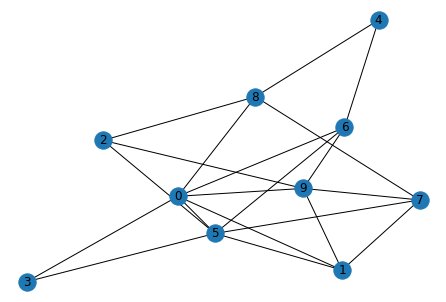

In [4]:
import networkx as nx

G = nx.erdos_renyi_graph(10, 0.4)
nx.draw(G, with_labels=True)

In [12]:
from networkx.utils import BinaryHeap

In [ ]:
from itertools import count

def _kernighan_lin_sweep(edges, side):

    # def _kernighan_lin_sweep(edges, side):
    # keep two min-heaps of swap costs to make optimal-next-move selection fast
    costs0, costs1 = costs = BinaryHeap(), BinaryHeap()

    # loop (number of edges, current community/side, list of edges)
    for u, side_u, edges_u in zip(count(), side, edges):
        
        # positive weight for nodes in group 1, negative for group 2
        cost_u = sum(w if side[v] else -w for v, w in edges_u)

        # get binaryHeap of current node, insert +1 if in group 1 else -1
        costs[side_u].insert(u, cost_u if side_u else -cost_u)


        # print(u, side_u, cost_u, edges_u, side)
        # print([w if side[v] else -w for v, w in edges_u])

    def _update_costs(costs_x, x):
        # loop through edges of x
        for y, w in edges[x]:
            # get side of y and its' cost
            costs_y = costs[side[y]]
            cost_y = costs_y.get(y)

            if cost_y is not None:
                cost_y += 2 * (-w if costs_x is costs_y else w)
                costs_y.insert(y, cost_y, True)


    i = totcost = 0
    while costs0 and costs1:
        u, cost_u = costs0.pop()
        _update_costs(costs0, u)
        v, cost_v = costs1.pop()
        _update_costs(costs1, v)
        totcost += cost_u + cost_v

        yield totcost, i, (u, v)

# costs0._dict, costs1._dict

In [25]:
# kernighan lin bisection

n = len(G)
labels = list(G)
index = {v: i for i, v in enumerate(labels)}

# assume no partition - first half as group 0 and second half as group 1
side = [0] * (n // 2) + [1] * ((n + 1) // 2)

# adjacency list, ordered by nodes v. Weights all 1
edges = [[(index[u], 1) for u, e in G[v].items()] for v in labels]

max_iter = 10
for i in range(max_iter):
    costs = list(_kernighan_lin_sweep(edges, side))

    min_cost, min_i, _ = min(costs)

    if min_cost >= 0:
        break

    for _, _, (u, v) in costs[:, min_i+1]:
        side[u] = 1
        side[v] = 0

A = {u for u, s in zip(labels, side) if s == 0}
B = {u for u, s in zip(labels, side) if s == 1}

A, B

TypeError: list indices must be integers or slices, not tuple

In [47]:
def _get_adjacent_cliques(clique, membership_dict):
    adjacent_cliques = set()
    # for each node in the clique
    for n in clique:
        # find other cliques that node n belongs to
        for adj_clique in membership_dict[n]:
            # for adjacent cliques
            if clique != adj_clique:
                adjacent_cliques.add(adj_clique)

    return adjacent_cliques

[frozenset({0, 1, 3, 5, 6, 7, 9})]

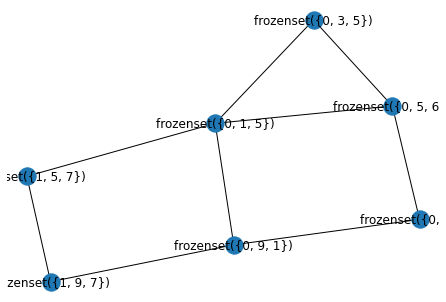

In [53]:
from collections import defaultdict

def k_clique_communities(G, k=3, cliques=None):
    # find all maximum cliques. TODO - write from scratch
    cliques = nx.find_cliques(G)
    # list(cliques)

    cliques = [frozenset(c) for c in cliques if len(c) >= k]
    # cliques

    # first index which nodes are in which cliques
    membership_dict = defaultdict(list)
    for clique in cliques:
        for node in clique:
            membership_dict[node].append(clique)

    #  for each clique, see which adjacent cliques percolate
    perc_graph = nx.Graph()
    perc_graph.add_nodes_from(cliques)
    # for each clique
    for clique in cliques:
        # for each adjacent cliques (defined as cliques whose nodes belong to the current clique)
        for adj_clique in _get_adjacent_cliques(clique, membership_dict):
            # find two common cliques with at least k-1 common nodes
            if len(clique.intersection(adj_clique)) >= (k-1):
                perc_graph.add_edge(clique, adj_clique)

    nx.draw(perc_graph, with_labels=True)

    for component in nx.connected_components(perc_graph):
        yield (frozenset.union(*component))

list(k_clique_communities(G, 3))

In [91]:
# greedy modularity communities

from networkx.algorithms.community.quality import modularity
from networkx.utils.mapped_queue import MappedQueue

# count nodes and edges
N = len(G)
m = sum([1 for u, v in G.edges()])
q0 = 1.0 / (2.0 * m)

# map node labels to contiguous integers
label_for_node = {i: v for i, v in enumerate(G)}
node_for_label = {label_for_node[i]: i for i in range(N)}

# calculate degrees of nodes
k_for_label = G.degree(G.nodes())
k = [k_for_label[label_for_node[i]] for i in range(N)]

# initialise community and merge lists
# each node belongs to different communities
communities = {i: frozenset([i]) for i in range(N)}
merges = []

# initialize modularity
partition = [[label_for_node[x] for x in c] for c in communities.values()]
q_cnm = modularity(G, partition)

# initialize data structures (degree / 2m)
a = [k[i] * q0 for i in range(N)]
# node:neighbor mapping
dq_dict = {
    i: {
        j: 2*q0 - 2*k[i]*k[j]*q0*q0
        # for all neighbors
        for j in [node_for_label[u] for u in G.neighbors(label_for_node[i])]
        if j != i
    }
    for i in range(N)
}

# (-dq value, node, neighbor)
dq_heap = [
    MappedQueue([(-dq, i, j) for j, dq in dq_dict[i].items()]) for i in range(N)
]
# get neighbor with the largest dq value (or most negative -dq)
H = MappedQueue([dq_heap[i].h[0] for i in range(N) if len(dq_heap[i]) > 0])

# merge communities until we can't improve modularity
# loop over each nodes
while len(H) > 1:
    # remove from heap
    try:
        dq, i, j = H.pop()
    except IndexError:
        break

    # get the original dq value
    dq = -dq

    # remove best merge from row i heap
    dq_heap[i].pop()

    # push new row max onto H
    if len(dq_heap

In [97]:
# naive greedy modularity communities

# create one community for each node
communities = list([frozenset([u]) for u in G.nodes()])
# track merges
merges = []
# greedily merge communities until no improvement is possible
old_modularity = None
new_modularity = modularity(G, communities)

# keep looping while modularity improvement is still possible
while old_modularity is None or new_modularity > old_modularity:
    old_modularity = new_modularity

    # find best pair to merge
    trial_communities = list(communities)
    to_merge = None

    # go through each pair of communities
    for i, u in enumerate(communities):
        for j, v in enumerate(communities):
            # only explore half diagonal or the communities
            if j <= i or len(u) == 0 or len(v) == 0:
                continue

            # merge communities u and v
            # try to merge community u and v (i to j)
            trial_communities[j] = u | v
            trial_communities[i] = frozenset([])

            # measure new modularity
            trial_modularity = modularity(G, trial_communities)

            # check if modularity is higher
            if trial_modularity >= new_modularity:
                # check if strictly better or tie
                    if trial_modularity > new_modularity:
                        new_modularity = trial_modularity
                        # (community i, community j, modularity improvement)
                        to_merge = (i, j, new_modularity - old_modularity)
                    elif to_merge and min(i, j) < min(to_merge[0], to_merge[1]):
                        # break ties by choosing pair with lowest min id
                        new_modularity = trial_modularity
                        to_merge = (i, j, new_modularity - old_modularity)

            # un-merge to try next
            trial_communities[i] = u
            trial_communities[j] = v

    # to_merge is none if there's no more modularity improvement possible
    if to_merge is not None:
        merges.append(to_merge)
        i, j, dq = to_merge
        u, v = communities[i], communities[j]
        communities[j] = u | v
        communities[i] = frozenset([])
        print(i, j, dq)

# remove empty communities and sort
communities = [c for c in communities if len(c) > 0]
communities

4 8 0.04000000000000001
0 3 0.03499999999999998
3 5 0.039999999999999994
2 9 0.03125
1 7 0.03
5 6 0.03
7 9 0.01999999999999999


[frozenset({0, 3, 5, 6}), frozenset({4, 8}), frozenset({1, 2, 7, 9})]

In [98]:
# luke's partitioning - partition a weighted tree (connected, acyclic graph featuring integer node weights and float edge weights). Total weight of nodes in each cluster does not exceed max_size, minimise weight of cut edges

nx.is_tree(G)

False

In [135]:
from collections import Counter
import numpy as np
from networkx.utils import groups

# label propagation

# def asyn_lpa_communities

labels = {n: i for i, n in enumerate(G)}
cont = True

while cont:
    cont = False

    nodes = list(G)
    np.random.shuffle(nodes)

    # loop through each node
    for node in nodes:
        # if no neighbor
        if len(G[node]) < 1:
            continue

        label_freq = Counter()
        # count number of unique labels
        for v in G[node]:
            label_freq.update(
                { labels[v]: 1 }
            )

        # find most frequent label
        max_freq = max(label_freq.values())
        # list of communities with highest frqeuency
        best_labels = [
            label for label, freq in label_freq.items() if freq == max_freq
        ]

        # print(best_labels, max_freq)

        # if current label is not the best, change
        if labels[node] not in best_labels:
            labels[node] = np.random.choice(best_labels)
            cont = True

    
# groups(labels).values()
labels

{0: 3, 1: 1, 2: 2, 3: 3, 4: 2, 5: 3, 6: 3, 7: 1, 8: 2, 9: 1}

In [141]:
# # semi-synchronous label propagation algorithm

# # color network so that neighboring nodes all have distinct colors
# coloring = dict()
# colors = nx.coloring.greedy_color(G)
# for node, color in colors.items():
#     if color in coloring:
#         coloring[color].add(node)
#     else:
#         coloring[color] = {node}
# # coloring is {color: {nodes}}

# # create unique label for each node
# labeling = {v: k for k, v in enumerate(G)}

# # check labeling complete

# labeling

In [150]:
# # fluid communities algorithm

# # initial number of communities
# k =3 

# # initialisation
# max_density = 1.0
# vertices = list(G)
# np.random.shuffle(vertices)
# communities = {n: i for i, n in enumerate(vertices[:k])}
# density = {}
# com_to_numvertices = {}

# for vertex in communities.keys():
#     com_to_numvertices[communities[vertex]] = 1
#     density[communities[vertex]] = max_density

# # setup control variables and start iterating
# iter_count = 0
# cont = True
# while cont:
#     cont = False
#     iter_count += 1
#     # loop over all vertices
#     vertices = list(G)
#     np.random.shuffle(vertices)

#     for vertex in vertices:
#         com_counter = Counter()
#         com_counter.update({communities[vertex]: density[communities[vertex]]})

#     break

# com_counter

In [171]:
import matplotlib.pyplot as plt
# girvan-newman algorithm
# repeated remove the most valuable edge (highest betweenness)

# find edge with highest betweenness centrality
def most_valuable_edge(G):
    betweenness = nx.edge_betweenness_centrality(G)
    return max(betweenness, key=betweenness.get)

# most_valuable_edge(G)

g = G.copy()
while g.number_of_edges() > 0:
    # without most central edges
    # find how many connected components
    original_num_components = nx.number_connected_components(G)
    num_new_components = original_num_components
    # repeat until components break
    while num_new_components <= original_num_components:
        # find most valuable edge
        edge = most_valuable_edge(g)
        # remove that edge
        g.remove_edge(*edge)
        # find new connected components
        new_components = tuple(nx.connected_components(g))
        num_new_components = len(new_components)

        # nx.draw(g)
        # plt.show()

    # communities at different level
    print(new_components)

({0, 1, 2, 3, 5, 6, 7, 9}, {8, 4})
({0, 1, 2, 3, 5, 6, 7, 9}, {8, 4})
({0, 1, 3, 5, 6, 7, 9}, {2}, {8, 4})
({0, 1, 3, 5, 6, 7, 9}, {2}, {8, 4})
({0, 1, 3, 5, 6, 7, 9}, {2}, {8, 4})
({0, 1, 5, 6, 7, 9}, {2}, {3}, {8, 4})
({0, 1, 5, 6, 7, 9}, {2}, {3}, {8, 4})
({0, 1, 5, 6, 7, 9}, {2}, {3}, {8, 4})
({0, 1, 5, 6, 7, 9}, {2}, {3}, {8, 4})
({0, 5, 6}, {1, 9, 7}, {2}, {3}, {8, 4})
({0, 5, 6}, {1, 9, 7}, {2}, {3}, {8, 4})
({0}, {1, 9, 7}, {2}, {3}, {8, 4}, {5, 6})
({0}, {1, 9, 7}, {2}, {3}, {8, 4}, {5, 6})
({0}, {1}, {2}, {3}, {8, 4}, {5, 6}, {9, 7})
({0}, {1}, {2}, {3}, {4}, {5, 6}, {9, 7}, {8})
({0}, {1}, {2}, {3}, {4}, {5}, {6}, {9, 7}, {8})
({0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9})


In [193]:
# performance of partition
partition = [{i} for i in G]

# compute the number of intra-community edges
intra_community_edges = sum([G.subgraph(block).size() for block in partition])
# compute the number of inter-community edges
inter_community_non_edges = nx.quotient_graph(nx.complement(G), partition, create_using=nx.MultiGraph).size()

n = len(G)
total_pairs = n * (n-1) // 2

(intra_community_edges + inter_community_edges) / total_pairs

0.4444444444444444

In [194]:
# coverage of partitions

partition = [{i} for i in G]

intra_community_edges = sum([G.subgraph(block).size() for block in partition])
total_edges = G.number_of_edges()

intra_community_edges/total_edges

0.0

In [206]:
# modularity

out_degree = in_degree = dict(G.degree())
deg_sum = sum(out_degree.values())
m = deg_sum / 2
norm = 1 / deg_sum ** 2

def community_contribution(community):
    comm = set(community)
    # sum of edges within community
    L_c = sum(1 for u, v in G.edges(comm) if v in comm)

    out_degree_sum = in_degree_sum = sum(out_degree[u] for u in comm)

    return L_c / m - out_degree_sum * in_degree_sum * norm

sum(map(community_contribution, partition))

-0.11124999999999999

{2, 5, 9}